In [2]:
# Import packages
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.tsa.stattools as ts
from matplotlib import pyplot as plt
import statistics
import math
from sklearn.preprocessing import StandardScaler
from numpy.linalg import eig
from scipy import linalg as la
from scipy.stats import mode
from skrmt.ensemble import GaussianEnsemble, marchenko_pastur_law
import scipy

from sklearn.cluster import KMeans
from sklearn.metrics import homogeneity_score, completeness_score,v_measure_score
import networkx as nx

In [3]:
fut_list = ['ES=F','CL=F','ZN=F','^VIX','DX-Y.NYB']
data= yf.download(fut_list, start="2017-01-01", end="2023-02-22")['Close']
fut_list2 = ['ES=F','CL=F','ZN=F','^VIX','DX-Y.NYB']
data2= yf.download(fut_list, start="2023-02-01", end="2023-02-22")['Close']

[*********************100%***********************]  5 of 5 completed
[*********************100%***********************]  5 of 5 completed


In [4]:
x=pd.DataFrame(data=data)
log = np.log(x/x.shift())
log_corr = pd.DataFrame(data=log.corr())
ee,ev=la.eig(log_corr)

xx=pd.DataFrame(data=data2)
log2 = np.log(xx/xx.shift())
log_corr2 = pd.DataFrame(data=log2.corr())
ee_feb,ev_feb=la.eig(log_corr2)
log.iloc[1320]

C:\Users\Chetan\anaconda3\lib\site-packages\pandas\core\internals\blocks.py:402: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


CL=F        0.033767
DX-Y.NYB   -0.006218
ES=F       -0.006398
ZN=F        0.002424
^VIX        0.022496
Name: 2022-03-30 00:00:00, dtype: float64

In [5]:
ev2 = np.diag(ev.sum(axis=1))
print(ev2)

[[-0.76562168  0.          0.          0.          0.        ]
 [ 0.         -1.40868565  0.          0.          0.        ]
 [ 0.          0.          1.54515931  0.          0.        ]
 [ 0.          0.          0.         -0.20461682  0.        ]
 [ 0.          0.          0.          0.          0.00654676]]


In [6]:
def create_combined_array(n, func):
    combined_array = []
    for i in range(n):
        new_array = func(i)  
        flattened_array = np.ndarray.flatten(new_array)  
        combined_array += flattened_array.tolist()  
    return combined_array

In [7]:
def create_correlation_matrices(data, chunk_size=30):
    corr_matrices = []
    n_rows = data.shape[0]
    for i in range(0, n_rows, chunk_size):
        chunk = data[i:i+chunk_size]
        corr_matrix = np.corrcoef(chunk, rowvar=False)
        corr_matrices.append(corr_matrix)
    return corr_matrices

In [8]:
corr_matrices = create_correlation_matrices(log,10)
x = np.nan_to_num(corr_matrices, posinf = 0)

In [9]:
def get_eigenvalues_eigenvectors(corr_matrices):
    eigenvalues = []
    eigenvectors = []
    
    for corr_matrix in corr_matrices:
        eig_vals, eig_vecs = np.linalg.eig(corr_matrix)
        eigenvalues.append(eig_vals)
        eigenvectors.append(eig_vecs)
    
    return eigenvalues, eigenvectors

In [10]:
ev

array([[ 0.33007661, -0.04255138, -0.9390618 , -0.03589968, -0.07818542],
       [-0.14887225, -0.71921384,  0.03237104,  0.09781469, -0.67078529],
       [ 0.65105429,  0.06190574,  0.20642438,  0.72147517, -0.09570028],
       [-0.20125823,  0.69065839, -0.04612165,  0.04379866, -0.69169399],
       [-0.63601094, -0.00891639, -0.2690294 ,  0.68315354,  0.23734996]])

In [11]:
values,vectors = get_eigenvalues_eigenvectors(x)

In [12]:
def vector_plot(x):
    for i, eig_vecs in enumerate(x):
        x = eig_vecs[:, 2]
        y = eig_vecs[:, 4]
        c = ev_feb[:, 4]
        d = ev_feb[:, 2]
        plt.scatter(x, y, c='blue')
        plt.scatter(c, d, c='red')   
    plt.xlabel("ES=F")
    plt.ylabel("VIX")
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    a = np.polyfit(c, d, 1)
    b = np.poly1d(a)
    plt.plot(x, p(x), c = 'blue')
    plt.plot(c,b(c), c = 'red')
    plt.show()

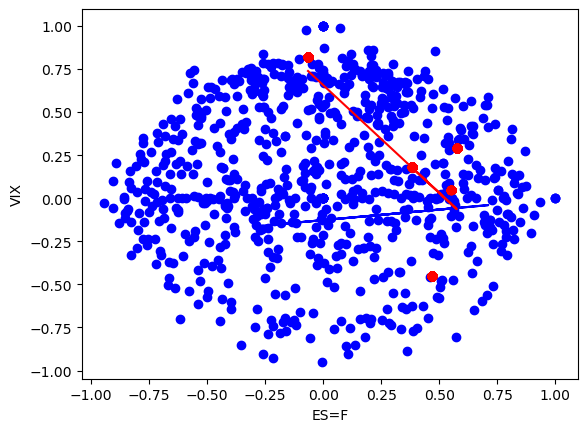

In [13]:
vector_plot(np.real(vectors))

In [14]:
def plot_eigenvalue(eigenvalues,time_interval):
    eigenvalue_2 = [eig_vals[2] for eig_vals in eigenvalues]
    time = [i*time_interval for i in range(len(eigenvalues))]
    
    plt.plot(time, eigenvalue_2)
    plt.xlabel("time")
    plt.ylabel("ES=F")
    plt.show()

In [15]:
def get_estimated_eigenvalues(corr_matrices):
    estimated_eigenvalues = []
    for corr_matrix in corr_matrices:
        n = corr_matrix.shape[0]
        sample_covariance = (n - 1) / n * np.cov(corr_matrix, rowvar=False, bias=True)
        eig_vals, _ = np.linalg.eig(sample_covariance)
        eig_vals_sorted = np.sort(eig_vals)[::-1]
        estimated_eigenvalues.append(eig_vals_sorted)
    return estimated_eigenvalues


def calc_eigenvalue_diffs(real_eigenvalues, estimated_eigenvalues):
    eigenvalue_diffs = []
    for i in range(len(real_eigenvalues)):
        diff = real_eigenvalues[i] - estimated_eigenvalues[i]
        eigenvalue_diffs.append(diff)
    return eigenvalue_diffs

In [16]:
estimated_eigenvalues = get_estimated_eigenvalues(x)

# Calculate the eigenvalue differences between the real and estimated eigenvalues for each matrix
eigenvalue_diffs = calc_eigenvalue_diffs(values, estimated_eigenvalues)

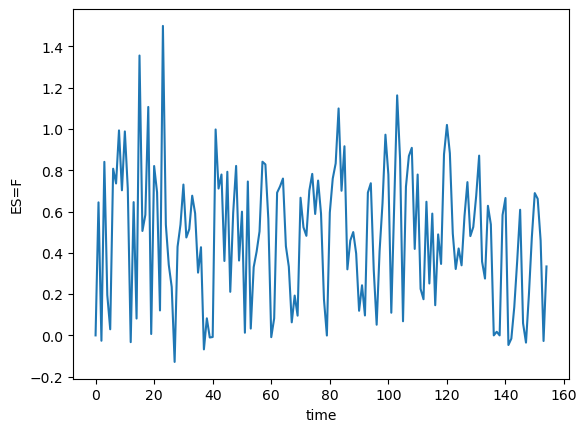

In [17]:
plot_eigenvalue(np.real(eigenvalue_diffs),1)

In [18]:
def plot_eigenvalue_boxplot(eigenvalues):
    # Extract all 5 eigenvalues for each matrix into a 2D array
    eigenvalues_all = np.array(eigenvalues)[:, :5]
    
    # Create a boxplot of all 5 eigenvalues
    plt.boxplot(eigenvalues_all, labels=["DXY", "CL=F", "ES=F",
                                          "ZN=F", "VIX"])
    plt.xlabel("Asset")
    plt.show()

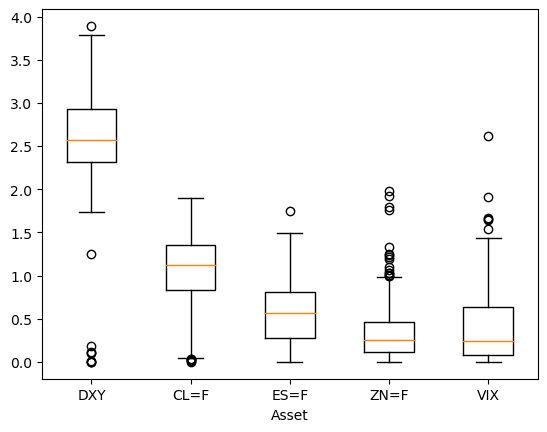

In [19]:
plot_eigenvalue_boxplot(np.real(values))

In [20]:
#corr_matrices
for i, corr_matrix in enumerate(corr_matrices):
    abs_corr = np.abs(corr_matrix)

In [21]:
G = nx.Graph()

In [22]:
#nodes
for j in range(corr_matrix.shape[0]):
        G.add_node(j+1)

In [23]:
#edges
for j in range(corr_matrix.shape[0]):
        for k in range(j+1, corr_matrix.shape[0]):
            G.add_edge(j+1, k+1, weight=abs_corr[j,k])

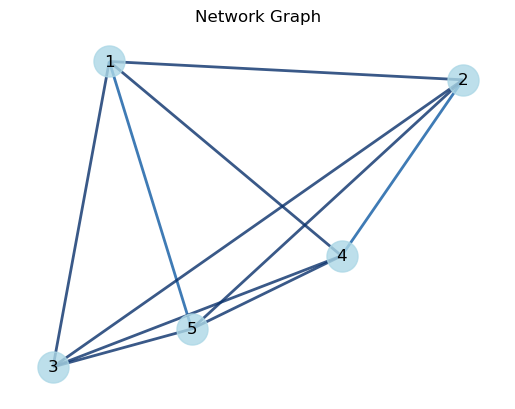

In [24]:
#draw graph
pos = nx.spring_layout(G, seed=42)
nx.draw_networkx_nodes(G, pos, node_size=500, node_color='lightblue', alpha=0.8)
nx.draw_networkx_edges(G, pos, width=2, edge_color=plt.cm.Blues(abs_corr[abs_corr>0.5]), alpha=0.8)
nx.draw_networkx_labels(G, pos, font_size=12, font_family='sans-serif')
plt.title(f"Network Graph")
plt.axis('off')
plt.show()

In [25]:
vector_array = np.array(vectors)
selected_eigenvectors = vector_array[:, :, [2, 4]]
data_reshaped = selected_eigenvectors.reshape(-1, 2)


In [26]:
k=5
kmeans = KMeans(n_clusters=k)
labels = kmeans.fit_predict(data_reshaped)

In [27]:
print('Cluster centers:')
print(kmeans.cluster_centers_)

Cluster centers:
[[-0.05480918 -0.01723801]
 [ 0.02091547  0.63158762]
 [ 0.60826551  0.05465282]
 [-0.60540423  0.04934755]
 [ 0.0760991  -0.60541379]]


In [28]:
print('Number of eigenvectors in each cluster:')
print(np.bincount(kmeans.labels_))

Number of eigenvectors in each cluster:
[135 225 161 162  92]


In [29]:
#SELECTION
corr_matrices2 = create_correlation_matrices(log2)
x2 = np.nan_to_num(corr_matrices[126:128], posinf = 0)

In [30]:
values1,vectors1 = get_eigenvalues_eigenvectors(x2)

In [31]:
vector_array1 = np.array(vectors1)
selected_eigenvectors1 = vector_array1[:, :, [2, 4]]
data_reshaped1 = selected_eigenvectors1.reshape(-1, 2)


In [32]:
data_reshaped1

array([[ 0.8622162 , -0.05387961],
       [ 0.12864155, -0.36720616],
       [-0.25531951,  0.62647876],
       [-0.02136447, -0.34967187],
       [ 0.41760039,  0.58950027],
       [ 0.2785251 , -0.43024809],
       [-0.80235393, -0.29159943],
       [-0.34567633,  0.51532984],
       [ 0.21823424, -0.46660268],
       [ 0.3339665 ,  0.49656163]])

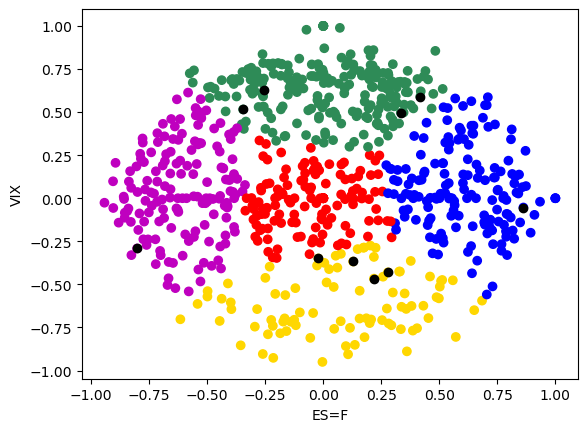

In [33]:
colors = ['red', 'seagreen', 'b', 'm', 'gold']
plt.scatter(data_reshaped[:, 0], data_reshaped[:, 1], c=[colors[c] for c in labels])
plt.scatter(data_reshaped1[:, 0], data_reshaped1[:, 1], c="black")
plt.xlabel('ES=F')
plt.ylabel('VIX')
plt.show()

In [34]:
real = np.array([[data_reshaped1[:, 0].mean(), data_reshaped1[:, 1].mean()]])

In [35]:
def find_cluster(data, cluster_centers, distance_threshold):
    """
    Find the cluster that the given data belongs to and return the index of the cluster and the distance
    of the data from the centerpoint of the cluster.
    
    Parameters:
    data (np.ndarray): A 2D NumPy array containing the data to be classified
    cluster_centers (list): A list of 2D NumPy arrays containing the centerpoints of the clusters
    distance_threshold (float): The distance threshold for each cluster
    
    Returns:
    int: The index of the cluster that the data belongs to
    float: The distance of the data from the centerpoint of the cluster
    """
    
    # Calculate the distances between the data point and each cluster centerpoint
    distances = [np.linalg.norm(data - centerpoint) for centerpoint in cluster_centers]
    
    # Find the index of the cluster with the smallest distance to the data point
    min_distance_index = np.argmin(distances)
    
    # Check if the distance to the closest cluster is less than or equal to the distance threshold
    if distances[min_distance_index] <= distance_threshold:
        # Return the index of the cluster and the distance to its centerpoint
        return min_distance_index, distances[min_distance_index]
    else:
        # If the data point is not within any cluster, return None
        return None, None

In [36]:
cluster_centers = kmeans.cluster_centers_
distance_threshold = 0.5

for point in real:
    cluster_index, distance = find_cluster(point, cluster_centers, distance_threshold)
    if cluster_index is not None:
        print(f"The point {point} belongs to cluster {cluster_index} and is {distance} units away from its centerpoint")
    else:
        print(f"The point {point} does not belong to any cluster")

The point [0.08144697 0.02686626] belongs to cluster 0 and is 0.14321636051325062 units away from its centerpoint


In [37]:
log.iloc[1260]

CL=F        0.011501
DX-Y.NYB    0.005940
ES=F        0.005762
ZN=F       -0.007936
^VIX       -0.036669
Name: 2022-01-03 00:00:00, dtype: float64